# Progetto CLS     (dataset CIFAR10)

Per questo progetto è stato utilizzato il dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) contenente 60000 immagini appartenenti a 10 classi distinte.  
L'obiettivo è quindi quello di creare opportuni modelli previsionali (nel contesto supervisionato) in grado di gestire questo tipo di classificazione.

Per il raggiungimento dell'obiettivo è stato deciso di 
Sono stati scelti 3 diversi modelli di Machine Learning supervisionato tra cui: K-Nearest-Neighbours, Random Forest ed inoltre un modello di deep learning (CNN). Dopo un'opportuna fase di grid-search con cross-validation degli iperparameteri, questi modelli sono stati tra loro confrontati in relazione ad una certa metrica di classificazione scoprendo che ........ risulta performare meglio rispetto agli altri.  

Le librerie utilizzate sono le seguenti:

In [1]:
import os, pickle, math, time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization

import tensorflow as tf


2022-09-12 21:47:16.629910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Descrizione dataset CIFAR10  

Il dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) consiste in una raccolta di 60000 immagini 32x32 a colori (3 canali RGB, ognuno con valori da 0 a 255) raggruppate in 10 classi ciascuna con 10000 immagini.  

Il dataset è disponibile sottofroma di 5 batches di train e 1 batch di test.  
Ciascun batch contiene esattamente 10000 immagini, di conseguenza il dataset finale sarà composto da 50000 immagini di train e 10000 immagini di test.   
Se per in ciascuno dei 5 batch di train le classi sono random e un batch potrebbe contenere più immagini di una classe rispetto che all'altra (comunque complessivamente il train è bilanciato), il batch di test è composto da esattamete 1000 immagini per classe. Inoltre, le classi sono tra loro mutuamente esclusive (un truck non è un automobile).  

Le immagini sono salvate in formato ROW-MAJOR STORAGE, ovvero l'intero dataset consiste in una matrice 60000x3072, in cui in ogni riga sono salvati prima tutti i 1024 (32x32) valori del canale RED, poi GREEN o poi BLUE.  

Le labels sono rappresentate tramite interi che vanno da 0 a 9 e il mapping con la relativa stringa è reso possibile grazie ad un particolare file di metadati fornito con il dataset. Le possibili classi sono le seguenti: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

In [2]:
def load_CIFAR10_batch(filename):
    """
    Caricamento singolo batch del dataset CIFAR-10.
    
    Return:
        - data['data']: np_array (10000 * 3072) uint8 (ogni elemento è 8 bit => 256 elementi) ROW-MAJOR STORAGE
                        
                        Ho quindi 10000 immagini ciascuna a 32x32=1024 pixel (ciascuno a 3 canali)
                        
                        ( R0,...,R1023, G0,...,G1023, B0,...,B1023) --> immagine 0
                             ...           ...           ...
                        ( R0,...,R1023, G0,...,G1023, B0,...,B1023) --> immagine 9999
                        
        - data['labels']: np_array (10000) contiene valori da 0 a 9 che indicano le 10 classi
                         
                        Il valore all'indice 'i' corrisponde alla classe dell'elemento i-esimo dell'array data['data']
                      
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
        return data['data'], np.array(data['labels'])
    
def load_CIFAR10(root_dir):
    """
    Caricamento completo del CIFAR-10. 
    Carico tutti e 5 i batch (ciascuno con 10000 immagini + 10000 labels) e poi carico il test set 
    (1000 immagini + 1000 labels) che è considerato come un ulteriore batch. Inoltre, leggo anche il file dei
    metadati per ottenere corrispondenza tra indice classe e nome classe (10 classi in tutto).
    
    TRAIN: 50000 immagini + 50000 labels
    TEST : 10000 immagini + 10000 labels
    
    Params:
        - root_dir: directory in cui è presente il dataset
        
    Return:
        - x: np_array (50000 * 3072) uint8 (tutte le 50000 immagini) ROW-MAJOR STORAGE
        - y: np_array (50000) uint8 con le 10 possibili classi 
        - x_test: np_array (10000 * 3072) uint8 (contiene 1000 immagini a caso da usare per il test)
        - y_test: np_array (10000) uint8 (classi delle 1000 immagini di test)
        - meta_data: array in cui sono presenti i nomi delle classi. Un nome della classe corrisponde al suo 
                     indice
    
    Link:
        np.concatenate : https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html
    """
    x = y = None
    for b in range(1,6):
        x_batch, y_batch = load_CIFAR10_batch(os.path.join(root_dir, 'data_batch_'+str(b)))
        x = np.concatenate((x, x_batch), axis=0) if x is not None else x_batch
        y = np.concatenate((y, y_batch), axis=0) if y is not None else y_batch
    x_test, y_test = load_CIFAR10_batch(os.path.join(root_dir, 'test_batch'))
    
    # Lettura metadati per nome delle classi
    meta_data = None
    with open(os.path.join(root_dir, 'batches.meta'), 'rb') as f:
        meta_data = pickle.load(f, encoding='latin1')
        
    return x, y, x_test, y_test, meta_data['label_names']

def display_CIFAR10(x, y, label_names, img_indices, size=(10, 10)):
    """
    Visualizzazione delle immagini come griglia.
    
    Params:
        - x: np_array (50000 * 3072) uint8 che dovrò trasformare in (50000 * 32 * 32 * 3) (cubo di img impilate)
        - y: np_array (50000) di labels corrispondenti
        - label_names: array dei nomi delle labels
        - img_indices: n-uple di indici delle immagini da visualizzare
        - size: (dim_x, dim_y) dimensione delle immagini
        
    Link:
        - https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html
    """
    x_reshaped = x.reshape(len(x), 3, 32, 32).transpose(0, 2, 3, 1)    # (50000 * 32 * 32 * 3)
    
    images = x_reshaped[img_indices]
    labels = y[img_indices]
    
    rows = columns = math.sqrt(len(img_indices))
    rows = round(rows)
    columns = round(columns) + 1 if (rows - round(columns)) != 0 else round(columns)
    
    fig=plt.figure(figsize=size)
    for i in range(1, len(img_indices) +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
        plt.title("{}".format(label_names[labels[i-1]]))
        
    plt.show()
    
    

Train image: (50000, 3072)
Train label: (50000,)
Test  image: (10000, 3072)
test  label: (10000,)
Labels:      airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck


                             Esempi casuali estratti dal dataset CIFAR10     



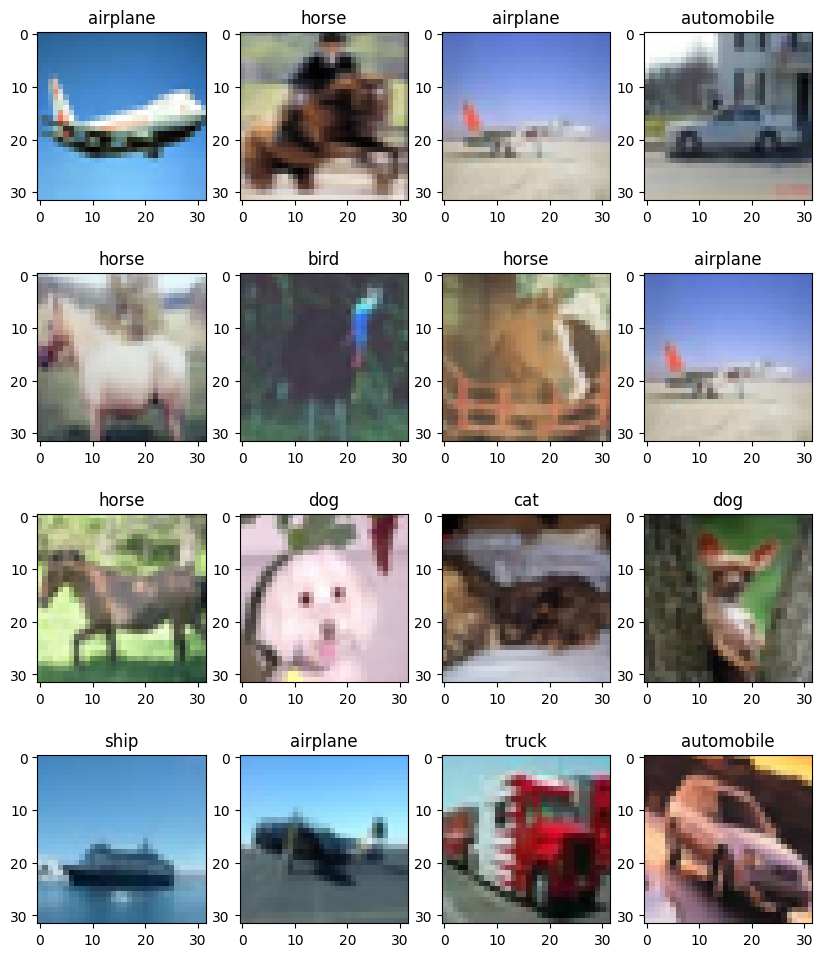

In [3]:
x_train, y_train, x_test, y_test, label_names = load_CIFAR10('./dataset/cifar-10-batches-py')
print('Train image: '+str(np.shape(x_train)))
print('Train label: '+str(np.shape(y_train)))
print('Test  image: '+str(np.shape(x_test)))
print('test  label: '+str(np.shape(y_test)))
print('Labels:      '+ ', '.join(label_names))

print('\n\n                             Esempi casuali estratti dal dataset CIFAR10     \n')
display_CIFAR10(x_train, y_train, label_names,
                img_indices=np.random.randint(0, len(x_train), 16),
                size=(10, 12))

## 1.1 Normalizzazione dataset  

Affinchè sia possibile usare i modelli di Machine Learning per questo tipo di dati, è necessario normalizzare le immagini.  
Se prima ogni pixel per ciascuno dei 3 canali aveva un range (0, 255), adesso voglio che il range diventi (0, 1).

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255.
x_test /= 255.

# 2. Machine Learnign  

I metodi di Machine Learning scelti al fine di effettuare previsioni multiclasse in un contesto supervisonato sul dataset CIFAR10, sono principalmente 3: K-Nearest-Neighbohurs, Logistic Regression e Random Forest.  

Per ciascuno di questi si vuole adottare una strategia di tuning degli iperparametri tramite grid-search con cross-validation per poi valutare i modelli sul test set così da poterli confrontare in relazione a precise metriche di classificazione.  

## 2.1 Metodologia tuning degli iperparametri  

Il concetto di base di questa metodologia consiste nel dividere inizialmente i dati in train e test set per poi, considerando solo la parte di train, effettuare cross-validation per ogni possibile configurazione dei parametri: quella che mi genera l'errore medio più basso in CV (in questo caso la metrica di errore è l'[accuratezza](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score)) allora risulta essere la configurazione migliore. Il meccanismo può essere schemaizzato con le seguente figura ([documentazione ufficiale scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)):  


<img src="./img/grid_search_cross_validation.png" alt="Drawing" style="width: 500px;"/>  


Esistono diverse possibili strategie di splitting della cross-validation ma per questa tipologia di problema la scelta è ricaduta sulla [K-Fold Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold): consiste nel suddividere in **k** gruppi i dati per poi considerarne **k-1** come train set e il restante come test set. Ad ogni iterazione di CV cambia il train e il test:  

<img src="./img/k-fold.png" alt="Drawing" style="width:500px"/>  

Una possibile altra scelta poteva ricadere sulla [Stratified K-Fold](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold) la quale ad ogni iterazione di CV sceglie un fold che rispetta la percentuale degli elementi nel rispetto del dataset inziale. Questa strategia è molto utile quando il dataset è sbilanciato.  

Per questo progetto è stato scelto di utilizzare una K-Fold Cross-Validation scegliendo come parametro **K=5**, ovvero effettuo 5 iterazioni di CV.

In [5]:
cv_strategy = KFold(n_splits=5)
i = 0
for train, test in cv_strategy.split(x_train):
    print("Iterazione CV: "+str(i))
    print("    Train dimensione "+str(len(train)))
    print("    Test  dimensione "+str(len(test)))
    i += 1

Iterazione CV: 0
    Train dimensione 40000
    Test  dimensione 10000
Iterazione CV: 1
    Train dimensione 40000
    Test  dimensione 10000
Iterazione CV: 2
    Train dimensione 40000
    Test  dimensione 10000
Iterazione CV: 3
    Train dimensione 40000
    Test  dimensione 10000
Iterazione CV: 4
    Train dimensione 40000
    Test  dimensione 10000


In [6]:
def grid_search(x, y, model, params):
    """
    Effettua il grid search degli iperparametri utilizzando una strategia di split CV di tipo K-Fold con k=5.
    I parametri migliori sono scelti in relazione ad una precisa metrica di errore che in questo caso è rappresentata
    dall'accuratezza.
    
    Params:
        - x: train set esempi su cui fare Grid-Search con Cross-Validation
        - y: train set label  su cui fare Grid-Search con Cross-Validation
        - model: modello ML da cui fare il tuning dei parametri
        - params: spazio dei parametri su cui trovare quelli migliori
        
    Return:
        - model_tuned: modello ML con i migliori parametri trovati tramite Grid-Search e riallenato su TUTTO x
        - res_grid_search: dizionario contenente le informazioni specifiche riguardanti il grid search con cross
                           validation:
                           - best_params: parametri migliori trovati dalla procedura di grid search
                           - refit_time: tempo (sec) di train su tutto x con i parametri migliori
                           - cv_result: risultati specifici di ogni passo della cross validation per ogni
                                        combinazione di parametri
        
    Link:
        - GridSearchCV : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
        - Scoring Grid-Search: https://scikit-learn.org/stable/modules/model_evaluation.html
    """
    cv_strategy = KFold(n_splits=5)
    model_tuned = GridSearchCV(model, 
                               param_grid=params, 
                               cv=cv_strategy, 
                               scoring='accuracy',
                               refit=True,
                              )
    model_tuned = model_tuned.fit(x, y)
    res_grid_search = {'best_params': model_tuned.best_params_,
                       'refit_time': model_tuned.refit_time_,   
                       'cv_results': model_tuned.cv_results_,
                      }
    
    return model_tuned, res_grid_search
    
def parameter_variation(interested_param, res_grid_search):
    """
    Crea un Dataframe Pandas che contiene l'evoluzione dell'errore del modello al variare di un certo parametro
    di interesse quando TUTTI gli altri parametri sono FISSATI al loro valore MIGLIORE trovato dalla 
    Grid-Search.

    IMPORTANTE: il parametro di interesse varierà SOLO tra quei valori ad esso impostati per la Grid-Search.

    Params:
        - interested_param: nome del parametro che si vuole studiare;
        - res_grid_search: secondo parametro ritornato dalla funzione 'grid_search()' che contiene le info
                           del Grid-Search

    Return:
        - df_res: Dataframe Pandas che contiene l'evoluzione dell'errore del modello al variare di un certo parametro
                  di interesse
    """
    best_params = res_grid_search['best_params']

    df_res = pd.DataFrame.from_dict(res_grid_search['cv_results'])

    def check_row(row):
        """
        Ritorna True solo se nella colonna 'params' è presente un dizionario in cui tutti i parametri tranne
        quello di interesse sono uguali ai parametri migliori trovati dalla Grid-Search.

        Params:
            - row: singola riga riferita alla sola colonna 'params'
        """
        for param_name, param_value in best_params.items():
            if param_name != interested_param:
                if row[param_name] != param_value:
                    return False
        return True

    df_res = df_res[df_res['params'].apply(check_row)]
        # aggiungo colonna al DF che corrisponde ai valori del parametro di interesse
        
    def set_value(row):
        """
        Problema: quando metto PCA nella Pipeline per fare Grid-Search, sono obbligato a definirlo in modo diverso
        dagli altri parametri: devo mettere un'istanza vera e propria di PCA così che posso valutare anche il caso
        in cui non la uso ('passthrough'). Con questa funzione, se il valore di una riga è un'istanza PCA, allora 
        ne ricavo il relativo valore di 'n_components'
        """
        val = row['params'][interested_param]
        if (type(val) == str) or (type(val) == int):
            if val == "passthrough":
                val = "No PCA"
            return val
        return str(val.n_components)+" comp."
        
    #df_res[interested_param] = df_res.apply(lambda x: x['params'][interested_param], 1)
    df_res[interested_param] = df_res.apply(lambda row: set_value(row), 1)
    df_res = df_res[[interested_param, 'mean_test_score', 'std_test_score']]

    return df_res

def plot_parameter_variation(interested_param, res_grid_search, title="Accuratezza modello", color="blue"):  
    """
    Effettua il plot di come varia l'accuracy del modello al variare del parametro di interesse nei vari
    passi della Grid-Search con Cross-Validation.
    
    Params:
        - interested_param: parametro di interesse di cui si vuole guardare la variazione
        - res_grid_search: secondo parametro ritornato dalla funzione 'grid_search()' che contiene le info
                           del Grid-Search  
        - title: titolo del grafico
        - color: colore delle barre. Possibili colori:
                 https://matplotlib.org/stable/gallery/color/named_colors.html
    """
    df_variation = parameter_variation(interested_param, res_grid_search).reset_index()
    
    label_with_std = [str(round(df_variation['mean_test_score'][i], 3))+"\n ± \n"+\
                      str(round(df_variation['std_test_score'][i], 3)) \
                      for i, _ in enumerate(df_variation[interested_param])]
    
    fig, ax1 = plt.subplots(nrows=1, figsize=(9, 4))
    range_x = np.arange(len(df_variation['mean_test_score']))
    
    ax1.plot(range_x, df_variation['mean_test_score'], label='Using set_dashes()', color="red")
    bar_ = ax1.bar(range_x, df_variation['mean_test_score'], 0.65, yerr=df_variation['std_test_score'], color=color)
    ax1.set_title(title)
    ax1.set_ylabel("Accuratezza")
    ax1.set_xlabel(interested_param)
    ax1.set_xticks(range_x, labels=df_variation[interested_param] )
    ax1.bar_label(bar_, label_type='center', labels=label_with_std)
    
    plt.show()
    

L'accuratezza è in sostanza il rapporto tra il numero di previsioni corrette e il totale.  

Questa metrica è usata sia come valore di confronto per il Grid-Search degli iperparametri che per la valutazione delle performance dei vari modelli una volta che sono stati valutati nel test set.  
E' stata ritenuta una scelta sensata in quanto le classi sono bilanciate e non si ricade nella situazione problematica che si verifica quando queste sono sbilanciate.

In [7]:
def eval_model(x, y, model_trained, invert_one_hot_encoding=False):
    """
    Funzione che si occupa di valutare nel test set (x, y) il modello allenato.
    Il risultato della valutazione è rappresentato tramite le metriche di accuracy, precision e recall.
    
    Params:
        - x: test set esempi su cui valutare il modello
        - y: test set label su cui valutare il modello
        - model_trained: modello allenato che voglio vautare
        - invert_one_hot_encoding: se passare da One-Hot-Encoding a singola previsione
        
    Return:
        - cls_report: {'0': {'precision': p, 'recall': r, 'f1-score': f, 'support': s},  |
                       ...                                                               | classi 0,..,9
                                                                                         |
                       '9': {'precision': p, 'recall': r, 'f1-score': f, 'support': s},  |
                       'accuracy': a,
                       'macro avg': {'precision': p, 'recall': r, 'f1-score': f, 'support': s}, 
                       'weighted avg': {'precision': p, 'recall': r, 'f1-score': f, 'support': s}
                      }
        - predictions: dizionario con valori reali e predetti
    """
    predicted_y = model_trained.predict(x)
    if invert_one_hot_encoding:                       # da One-Hot-Encoding a label intere
        predicted_y = np.argmax(predicted_y, axis=1)
        y_ = np.argmax(y, axis=1)
    else:
        y_ = y
    cls_report = metrics.classification_report(y_, predicted_y, output_dict=True)
    predictions = {'true': y_, 'predicted': predicted_y}
    return cls_report, predictions

def plot_evalueted_model(model_name, report, predictions, figsize=(6,6), title="Confusion Matrix"):
    """
    Questa funzione permette il display di:
        - accuratezza / precison media / recall media come dataframe pandas
        - confusion matrix della previsione
    
    Params:
        - model_name: nome del modello da valutare
        - report: 1° valore ritornato dalla funzione 'eval_model()'
        - predictions: 2° valore ritoranto dalla funzione 'eval_model()'
        - figsize: (x, y) dimensioni della confusion matrix
        - title: titolo sopra la confusion matrix
    """
    data = {model_name: [report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall']]}
    display(pd.DataFrame.from_dict(data, orient='index', columns=['accuracy', 'avg-precision', 'avg-recall']))
    
    fig, ax = plt.subplots(nrows=1, figsize=figsize)
    ax.set_title(title)
    metrics.ConfusionMatrixDisplay.from_predictions(predictions['true'], 
                                                    predictions['predicted'],
                                                    ax=ax,
                                                    display_labels=label_names,
                                                    xticks_rotation='vertical'
                                                   )
    plt.show()
    
def compare_report(cls_report_dict, compare_metric_list=['accuracy']):
    """
    Creazione di un dataframe Pandas in cui ogni colonna contiene un modello diverso e per ogni riga è presente una
    metrica di comparazione.
    
    Params:
        - cls_report_dict: {'model_name1': cls_report,    --> cls_report è ciò che ritorna 'eval_model()'
                                ...
                            'model_name2': cls_report,
                           }
        - compare_metric_list: lista che contiene una serie di metriche di comparazione.
                               E' possibile specificare una chiave innestata usando '|' 
                                 es: ['macro avg | precision']
                        
    Return:
        - Pandas Dataframe della forma (suppondendo compare_metric_list=['accuracy', 'macro avg | precision') 
        
                                  model_name1 .... model_nameN
                    
          accuracy                    x1      ....   xN
          macro avg - precision       y1      ....   yN
    
    """
    res_dict = {}
    
    for compare_metric in compare_metric_list:
        compare_metric_str = compare_metric
        compare_metric = [s.strip() for s in compare_metric.split("|")] # ['0 | precision'] --> ['0', 'precision']
        is_nested = len(compare_metric) > 1
        
        res_dict[compare_metric_str] = []          # es: {'accurcay': [] } --> per ogni modello appendo il valore
        
        for model_name in cls_report_dict.keys():
        
            value_to_compare = 0.
            if is_nested:            # max 2 livelli di innestamento
                value_to_compare = cls_report_dict[model_name][compare_metric[0]][compare_metric[1]]
            else:
                value_to_compare = cls_report_dict[model_name][compare_metric[0]]
            
            res_dict[compare_metric_str].append(value_to_compare)
            
    # res_dict è con la forma es: {'accurcay': [x1,...]} --> devo mettere come nome di colonne quello dei modelli  
    return pd.DataFrame.from_dict(res_dict, orient='index', columns=cls_report_dict.keys())  
    
def plot_compared_report(compared_report, 
                         color={},
                         title="Title",
                         width_bar=0.3,
                         fig_size=(9,4),
                         y_label="",
                         x_label="",
                        ):
    """
    Esegue il plot del report di comparazione creato con la funzione 'compare_report()'.
    
    Params:
        - compared_report: report comparato creato dalla funzione 'compare_report()'
        - color: dizionario con chiave il nome della colonna e valore il nome del colore relativo
        - title: titolo del grafico
        - width_bar: larghezz barre del grafico (0,..,1)
        - y_label: nome della label nell'asse y
        - x_label: nome della label nell'asse x
    """
    labels = compared_report.index
    x_range = np.arange(len(labels))
    
    n_cols = len(compared_report.columns)
    width_bar_group = width_bar * n_cols
    
    fig, ax = plt.subplots(figsize=fig_size)
    
    for id_col, column in enumerate(compared_report):
        bar = ax.bar((x_range - (width_bar_group/2)) + (id_col*width_bar) + width_bar/2, 
                     compared_report[column], 
                     width_bar, 
                     label=column,
                     color=color[column])
        ax.bar_label(bar, labels=["%.2f" % val for val in compared_report[column]])
    
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.set_xticks(x_range, labels)
    ax.legend()
    
    fig.tight_layout()
    
    plt.show()    
    

## 2.2 Creazione modelli  

Per la parte di Machine Learning è stato scelto di considerare i modelli supervisionati **K-Nearest-Neigbhors** e **Random Forest**. Se con il primo si vuole avere una sorta di ground-truth riguardo l'accuratezza ottenibile, con il secondo si vuole utilizzare un metodo d'insieme in cui la cooperazioni di più weak learner permette di ottenere un modello complessivo più accurato.  
Per entrambi si è inoltre voluto vedere come le cose cambiano se si utilizza o meno il modello non supervisionato **PCA** per la riduzione della dimensionalità (come mostrato in [questo](https://arxiv.org/pdf/1611.04905.pdf) articolo).  

### 2.2.1 PCA  

[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) è un algoritmo non supervisionato per la riduzione delle dimensionalità ovvero permette di passare da uno spazio dimensionalmente elevato ad uno ridotto. L'implementazione di base in scikit-learn si basa sull'algoritmo SVD (Singlolar Value Decomposition) che permette una riduzione lineare della dimensionalità, il cui relativo solver è scelto automaticamente in funzione della shape dei dati o del numero di componenti.  
Tra i vari parametri possibili, quello più importante è **n_components** che indica appunto il numero di componenti con cui si vuole effettuare la riduzione.  
Per ciascun modello previsionale considerato è stato inoltre trovato il valore di **n_components** della PCA che performa meglio. La strategia per la ricerca di questo parametro è sempre la Grid-Search con Cross-Validation (come mostrato nell'[esempio](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html)). I possibili valori del numero di componenti variano da 2 a 200.

In [8]:
PCA_SPACE = [PCA(2), PCA(30), PCA(200), PCA(500), "passthrough"]
    
def plot_pca_explained_variance(x, n_components):
    """
    Effettua il plot della varianza spiegata di 'n_components' componenti PCA.
    
    Params:
        - x: dataset su cui fare PCA
        - n_components: numero di componenti con cui fare PCA
    """
    pca_instance = PCA(n_components)
    pca_instance.fit(x)
    explained_variance_ratio = pca_instance.explained_variance_ratio_
    
    fig, ax0 = plt.subplots(nrows=1, figsize=(9, 4))
    ax0.plot(np.arange(1, n_components + 1), explained_variance_ratio, "+", linewidth=2)
    ax0.set_ylabel("PCA ratio varianza spiegata")
    ax0.set_title("Varianza spiegata PCA (n_components="+str(n_components)+")")
    
    plt.show()
    

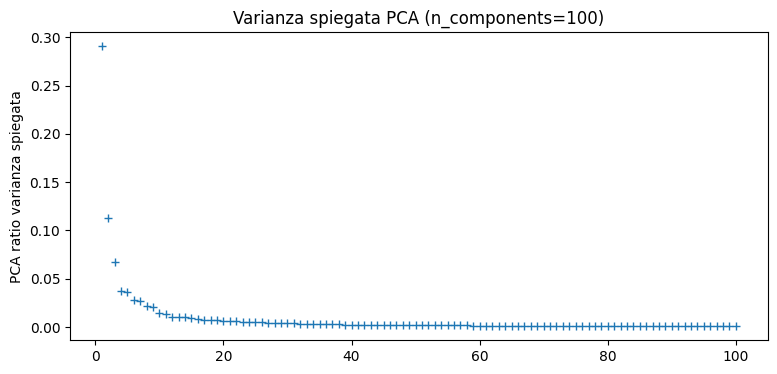

In [9]:

plot_pca_explained_variance(x_train, 100)


 

### 2.2.2 K-NearestNeighbors  

Il modello non-parametrico [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) implementa il learning sulla base dei k primi vicini rispetto al punto di query. In altre parole, dato un punto di query, gli viene assegnata la classe più frequente tra quelle dei k punti più vicini.  
I parametri più importanti sono i seguenti:  
- **n_neighbors**: (default = 5) è il valore di 'k'. Rappresenta il numero di primi vicini che vengono considerati quando è fatta una query di un nuovo punto. Valore alti di k 'sopprimono' il rumore ma rendono il confine di separazione più piccolo;
- **weights**: (default = uniform) ovvero che la classe associata al punto di query è calcolata 'a maggioranza' in cui tutti e k i vicini pesano uguale, ovvero gli viene associata la classe più frequente tra k punti più vicini. In alcuni casi è utile usare un tipo di pesaggio 'distance', ovvero che l'influenza di un vicino dipende dalla sua distanza dal punto di query;
- **metric**: (default = minkowski) è la metrica per la distanza.  Se metric = minkowski e p=2 allora è come dire che sto usando una distanza euclidea. Se p=1 sto usando ua distanza manhattan; 
- **p**: (default = 2) se p=1 è usata la distanza manhattan, se p=2 è usata la distanza euclidea (come usare L1 o L2).

Per quest modello è stato deciso di effettuare il grid search solo in riferimento al parametro di **n_neighbors**.  

Dopo di chè, si è voluto graficare, come mostrato nell' [esempio](https://github.com/shreyagu/kNN_CiFAR10dataset/blob/master/knn_CIFAR10.ipynb) come varia l'accuracy del modello al variare di k nella cross validation.

[PCA](https://arxiv.org/pdf/1611.04905.pdf)  [PCA Grid-Swarch](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html)

In [10]:
pipe_KNN = Pipeline(steps=[("pca", PCA()), ("knn", KNeighborsClassifier(weights='distance'))])

params = {"pca": PCA_SPACE,
          "knn__n_neighbors": [5, 10, 20],
         }        

model_KNN, res_grid_search_KNN = grid_search(x_train, y_train, pipe_KNN, params)

report_KNN, predictions_KNN = eval_model(x_test, y_test, model_KNN)

print('Parametri migliori : '+str(res_grid_search_KNN['best_params']))
print('Tempo (sec) di fit : '+str(res_grid_search_KNN['refit_time']))

Parametri migliori : {'knn__n_neighbors': 10, 'pca': PCA(n_components=30)}
Tempo (sec) di fit : 5.34869384765625


Dai risultati è possibile vedere che l'accuratezza media dei modelli KNN è influenzata dal numero di componenti scelte per la PCA: in particolare si può vedere che la scelta migliore ricade su un valore di componenti pari a 30.  
Inoltre, è riportato anche l'andamento dell'accuratezza al variare del numero di primi vicni (k) del modello. Tramite la fase di grid-Search con cross validation si è visto che il valore migliore è pari 10 ed inoltre il modello ha prestazioni migliori nel caso in cui il tipo di weight venga impostato a 'distance'.

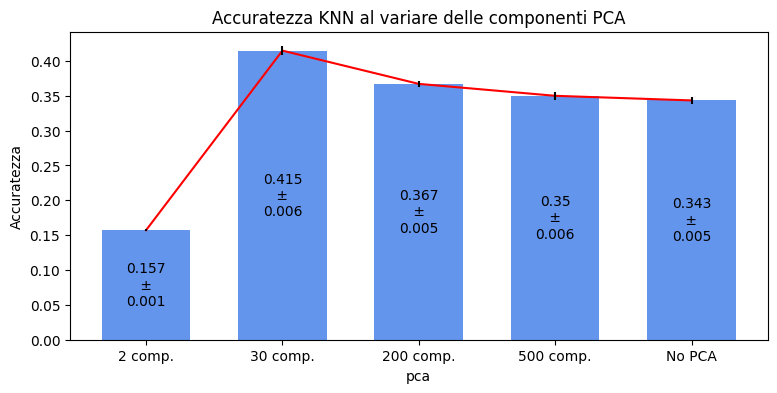

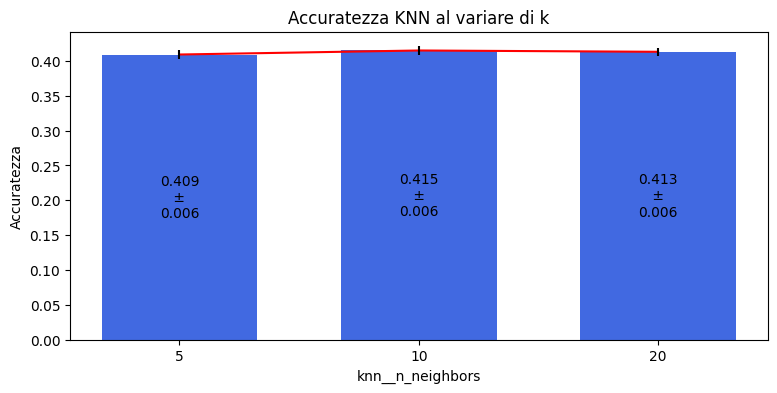

In [11]:
plot_parameter_variation('pca', res_grid_search_KNN, title="Accuratezza KNN al variare delle componenti PCA", color="cornflowerblue")

plot_parameter_variation('knn__n_neighbors', res_grid_search_KNN, title="Accuratezza KNN al variare di k", color="royalblue")


### 2.2.3 Random Forest  

Il modello di ensamble [RF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (Random Forest) consiste nell'utilizzare la strategia di Bootstrapping, ovvero definisce un certo numero di weak learner (alberi decisionali) ciascuno dei quali è allenato in un sottoinsieme del dataset così da ottenere modelli 'indipendenti' ed infine mediare il valore delle previsioni. Esistono molti parametri di tuning per questo tipo di modello ma ciò cdi cui ci si concentrerà è **n_estimator**, ovvero il numero di modelli deboli che fanno parte del metodo di insieme.

In [14]:
pipe_RF = Pipeline(steps=[("pca", PCA()), ("rf", RandomForestClassifier())])

params = {"pca": PCA_SPACE,
          "rf__n_estimators": [100, 500, 1000],
         }

model_RF, res_grid_search_RF = grid_search(x_train, y_train, pipe_RF, params)

report_RF, predictions_RF = eval_model(x_test, y_test, model_RF)

print('Parametri migliori : '+str(res_grid_search_RF['best_params']))
print('Tempo (sec) di fit : '+str(res_grid_search_RF['refit_time']))

Parametri migliori : {'pca': PCA(n_components=200), 'rf__n_estimators': 1000}
Tempo (sec) di fit : 1029.2218232154846


Dai risultati è possibile vedere che l'accuratezza media dei modelli RF è influenzata dal numero di componenti scelte per la PCA: in particolare si può vedere che la scelta migliore ricade su un valore di componenti pari a 30.
Inoltre, è riportato anche l'andamento dell'accuratezza al variare del numero estimator del modello, ovvero quanti weak learner è necessario considerare. Tramite la fase di grid-Search con Cross-Validation si è visto che il valore migliore è pari a 1000.

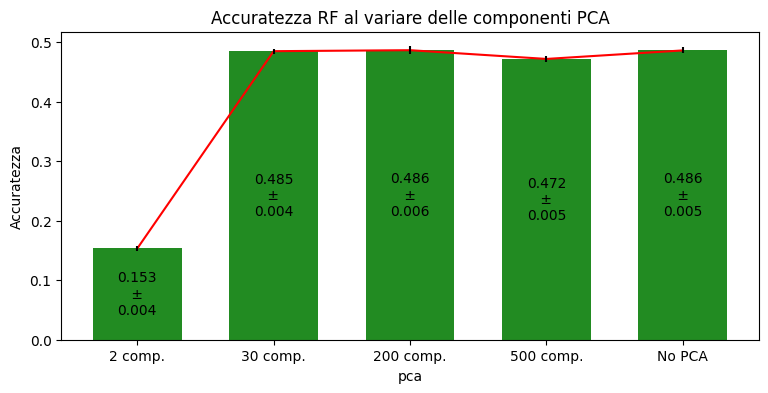

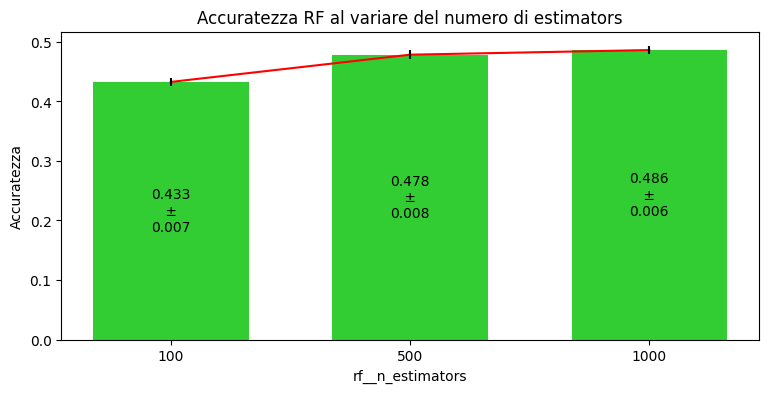

In [15]:
plot_parameter_variation('pca', res_grid_search_RF, title="Accuratezza RF al variare delle componenti PCA", color="forestgreen")

plot_parameter_variation('rf__n_estimators', res_grid_search_RF, title="Accuratezza RF al variare del numero di estimators", color="limegreen")


### 2.2.4 Convolutional Neural Network  

Per la risoluzione di questo problema è stato ritenuto ragionevole provare ad utilizzare una CNN, ovvero una rete neurale convoluzionale in grado di eseguire il task di classificazione sul dataset a noi a disposizione.  
La struttura della rete è stata presa sia dalla [documentazione ufficile](https://www.tensorflow.org/tutorials/images/cnn) di Tensorflow che alcuni articoli tra cui [1](https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c).

#### Preprocessing dati  

Per le reti neurali è necessario:
- fare un reshape dei dati in modo da ottenere una struttura del tipo (50000 x 32 x 32 x 3). Significa in sostanza che sono 50000 immagini di forma (32 x 32 x3) --> visualmente è come se impilassi 50000 immagini (32 x 32 x 3). Il batch_size è il primo valore della quadrupla (definito nel training).
- normalizzare tra 0 e 1 ogni elemento (questa normalizzazione è già stata fatta in precedenza e non devo rifarla). Perchè serve normalizzare? Perchè visto che si usa una funzione di attivazione RELU calcolata per ogni valore (pixel), se questi hanno un range tra 0 e 255 portano a valori molto grandi e di conseguenza si verifica il problema del [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
- trasformare le label in label [categoriche](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) ([One-Hot-Encoding](https://it.wikipedia.org/wiki/One-hot)) ovvero che la i- esima label corrisponda ad un vettore di tutti zeri tranne 1 nella posizione 'i'. Ogni label diventa una vettore e questo è necessario dal momento che si utilizza la [categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) come funzione di loss. Se si fosse usata la [sparse categorical crossentrpy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) allora questa trasformazione non sarebbe servita in quanto funzionerebbe anche con label intere.

In [16]:
x_train_nn = x_train.reshape(len(x_train), 3, 32, 32).transpose(0, 2, 3, 1)
x_test_nn = x_test.reshape(len(x_test), 3, 32, 32).transpose(0, 2, 3, 1)

num_classes = 10
y_train_nn = np_utils.to_categorical(y_train, num_classes)
y_test_nn = np_utils.to_categorical(y_test, num_classes)

print("Train: "+str(x_train_nn.shape))
print("Test : "+str(x_test_nn.shape))


Train: (50000, 32, 32, 3)
Test : (10000, 32, 32, 3)


#### Creazione modello  

La CNN implementata è presa spunto dal seguente [articolo](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/) e consiste in sostanza in una forte semplificazione dell'architettura [VGG](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/)(Visual Geometry Group), ovvero una struttura di rete convoluzionale multi-layer e profonda che si è rivelata molto efficiente nel campo del riconoscimento automatico di immagini. VGG-16 e VGG-19 sono le due principali implementazioni di questa architettura e si differenziano principalmente per il diverso numero di layer (16 e 19 rispettivamente).  

La rete di seguito sviluppata (principalmente per motivi di tempi di learning) implementa solamente i primi 4 layer di convoluzione più un'ultima parte costitutita da una fully-connected.  

In particolare i layer convolutivi [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) sono caratterizzati da un kernel 3x3, una funzione di attivazione di tipo ReLu (per conferire non-linearità al modello) ed inoltre è definito il padding a 'same' così da preservare la dimensione dell'input.  
E' stato deciso di utilizzare 4 layer di convoluzione distanziati a due a due da un livello di polling [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) con dimensioni 2x2 che permette di ridurre la dimensione l'output della metà.  

Finito lo stack convolutivo e dopo lo stato di [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), è inserita una fully connected con un singolo hidden layer [Dense](https://keras.io/api/layers/core_layers/dense/) di 128 nodi per poi terminare con il livello di output composto da 10 nodi caratterizzati da una funzione di attivazione di tipo [softmax](https://en.wikipedia.org/wiki/Softmax_function) che mi permette di avere un vettore di 10 probabilità (un valore per classe), ovvero la somma dei 10 nodi di output deve sommare a 1.  

Una volta definito, il modello è poi compilato tramite la funzione [compile](https://keras.io/api/models/model_training_apis/): questa permette di definire sia l'algoritmo di ottimizzazione stocastico che la funzione di loss e le metriche da tenere in considerazione. In questo caso è stato scelto:
- [SGD](https://keras.io/api/optimizers/sgd/)(Gradient Descent con Momentum) come metodo di ottimizzazione stocastica a varianza ridotta che si basa sull'idea di 'ricordarsi' i gradienti calcolati in precedenza così da tendere a quelo full. Il termine momentum è quel termine che mi permette di impostare in che modo e con quale peso considerare i gradienti calcolati in precedenza (default solitamente è 0.9). Il learning rate permette invece di specificare la grandezza del passo del gradiente per avvicinarsi al minimo della loss
- [categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) come funzione di loss in grado di misurare la 'distanza' tra il vettore predetto e il vettore reale delle label (si parla di vettore perchè è stata fatta una trasformazione One-Hot-Encoding)
scelta la funzione di loss di tipo categorical cross entropy che permette di confrontare il vettore di probabilità reale (label) con quello predetto dalla rete e misura quanto differiscono.


In [17]:
model_CNN = models.Sequential()
model_CNN.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_CNN.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_CNN.add(layers.MaxPooling2D((2, 2)))
model_CNN.add(Dropout(0.3))
model_CNN.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_CNN.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_CNN.add(layers.MaxPooling2D((2, 2)))
model_CNN.add(Dropout(0.3))

model_CNN.add(layers.Flatten())
model_CNN.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_CNN.add(Dropout(0.3))
model_CNN.add(layers.Dense(10, activation='softmax'))

model_CNN.summary()

model_CNN.compile(optimizer=SGD(lr=0.001, momentum=0.9),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=["accuracy"])


2022-09-13 08:58:52.571450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

#### Learning   

IMPORTANTE: se chiamo il fit due volte consecutive, la seconda volta parte dal modello già allenato nel fit precedente !  

Il [fit](https://keras.io/api/models/model_training_apis/#fit-method) della rete funziona in batches (guarda gradiente stocastico), ovvero ad ogni iterazione estraggo casualmente batch_size (es. 64) immagini dal dataset, ciascuna delle quali viene messa in input in maniera sequenziale alla rete. In questo modo si riesce a calcolare la loss mediata delle 64 immagini per poi trovare con la backpropagation il gradiente (relativo alla loss delle sole 64 img) ed infine effettuare il passo del gradiente (in cui *alpha* o *learning rate* ne deterimna la lunghezza) per l'aggiornamento dei pesi della rete.  

E' stato quindi detto che ad ogni iterazione il modello prende casualmente 64 immagini e con le stesse è in grado di capire come cambiare i pesi di tutta la rete.  
Quando il modello ha visto in media tutto il dataset si dice che è stata fatta un'*epoca* di train. Si può quindi vedere dai risultati sotto riportati che ad ogni epoca sono fatte 625 iterazioni in cui per ciascuna sono estratte casualmente 64 immagini e quindi 625 x 64 fa 40000 (in quanto il 20% (10000) è stato riservato al validation).

Alla fine di ciascuna epoca è riportato il valore della loss e dell'accuracy sul train set e sul validation set.

Il validation set può essere specificato manualmente utilizzando il parametro *validation_data* oppure con il parametro *validation_split* si imposta la percentuale di dati di train che devono essere riservati al validation e non usati per l'addestramento come mostrato nel seguente [articolo](https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/).


In [18]:
history = model_CNN.fit(x_train_nn, y_train_nn, 
                        epochs=35, batch_size=64,
                        validation_split=0.2)


Epoch 1/35
625/625 [==============================] - 155s 245ms/step - loss: 2.0556 - accuracy: 0.2303 - val_loss: 1.7641 - val_accuracy: 0.3672
Epoch 2/35
625/625 [==============================] - 155s 248ms/step - loss: 1.7306 - accuracy: 0.3639 - val_loss: 1.5742 - val_accuracy: 0.4400
Epoch 3/35
625/625 [==============================] - 147s 234ms/step - loss: 1.5966 - accuracy: 0.4147 - val_loss: 1.4794 - val_accuracy: 0.4753
Epoch 4/35
625/625 [==============================] - 146s 234ms/step - loss: 1.5051 - accuracy: 0.4498 - val_loss: 1.4147 - val_accuracy: 0.4978
Epoch 5/35
625/625 [==============================] - 146s 234ms/step - loss: 1.4319 - accuracy: 0.4769 - val_loss: 1.3283 - val_accuracy: 0.5295
Epoch 6/35
625/625 [==============================] - 147s 235ms/step - loss: 1.3725 - accuracy: 0.4994 - val_loss: 1.2733 - val_accuracy: 0.5494
Epoch 7/35
625/625 [==============================] - 147s 235ms/step - loss: 1.3217 - accuracy: 0.5240 - val_loss: 1.2086 -

#### Learning evaluation  

Sulla base della history ritornata dal fit della rete sono visualizzati gli andamenti di loss e accuracy sul train e sul validation all'aumentare del numero di epoche di train

In [19]:
def plot_history(history, measure, fig_size=(10,8), title="CNN train result"):
    """
    Visualizza il grafico di loss e accuracy all'aumentare del numero delle epoche di train.
    
    Params:
        - history: ritornata dalla funzione 'fit()' di train
        - measure: 'loss' o 'accuracy'
        - fig_size: (x, y)
        - title: titolo del grafico
    """
    fig, ax = plt.subplots(figsize=fig_size)
    
    ax.plot(history.history[measure], label=measure)
    ax.plot(history.history["val_"+measure], label = "val_"+measure)
    
    ax.set_ylabel(measure)
    ax.set_xlabel("epoche")
    ax.set_title(title)
    ax.legend()
    
    if measure == "accuracy":
        ax.set_ylim(0.0, 1)
    
    plt.show() 
    

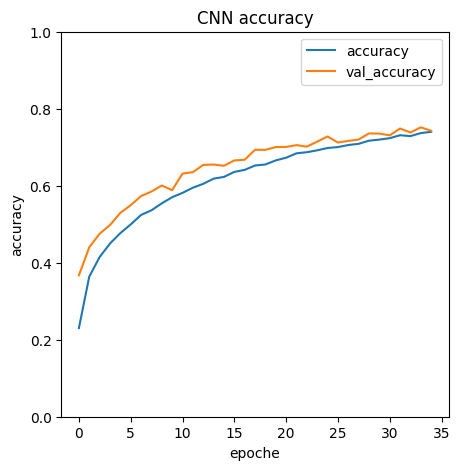

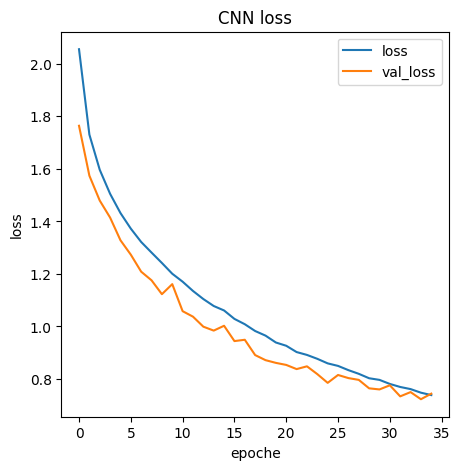

In [20]:
plot_history(history, 'accuracy', fig_size=(5, 5), title="CNN accuracy")
plot_history(history, 'loss', fig_size=(5, 5), title="CNN loss")

## 3 Valutazione modelli  

Di seguito si vogliono riportare e mettere a confronto le performance dei modelli in relazione all'accuratezza generale che questi hanno sul test set ed inoltre anche alla precisione relativa alle singole classi.  
Se per lo studio dei singoli modelli è riportata la relativa [confusion matrix](https://stats.stackexchange.com/questions/51296/how-do-you-calculate-precision-and-recall-for-multiclass-classification-using-co), per il confronto tra i modelli è stato scelto di riportare la [precision](https://stats.stackexchange.com/questions/51296/how-do-you-calculate-precision-and-recall-for-multiclass-classification-using-co) relativa ad ogni singola classe.

### 3.1 K-Nearest-Neighbors  

Sono di seguito riportati i risultati relativi alla valutazione del modello KNN sull'intero test set.

,accuracy,avg-precision,avg-recall
K-Nearest-Neighbours,0.4305,0.457642,0.4305


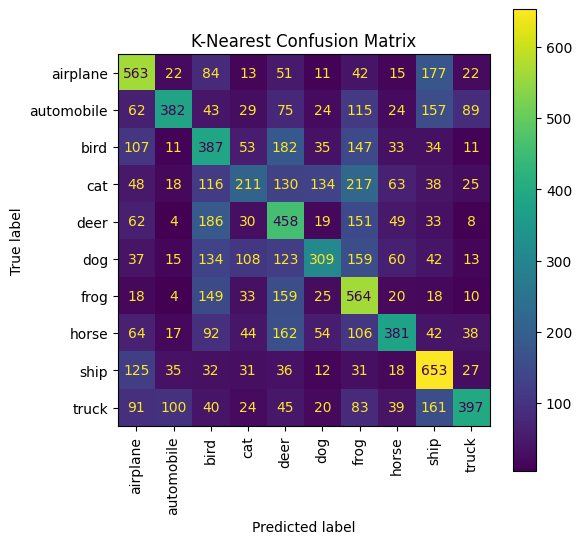

In [21]:
plot_evalueted_model("K-Nearest-Neighbours", report_KNN, predictions_KNN, title="K-Nearest Confusion Matrix")


### 3.2 Random Forest 

Sono di seguito riportati i risultati relativi alla valutazione del modello RF sull'intero test set.

,accuracy,avg-precision,avg-recall
Random Forest,0.5001,0.495726,0.5001


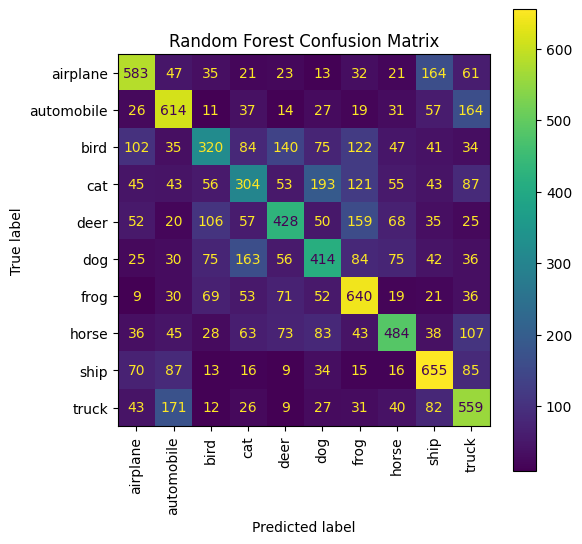

In [22]:
plot_evalueted_model("Random Forest", report_RF, predictions_RF, title="Random Forest Confusion Matrix")


### 3.4 Convolutional Neural Network  

Risultati di previsione della CNN su tutto il test set.

Keras accuracy: 0.7303000092506409
313/313 [==============================] - 10s 32ms/step


,accuracy,avg-precision,avg-recall
CNN,0.7303,0.734337,0.7303


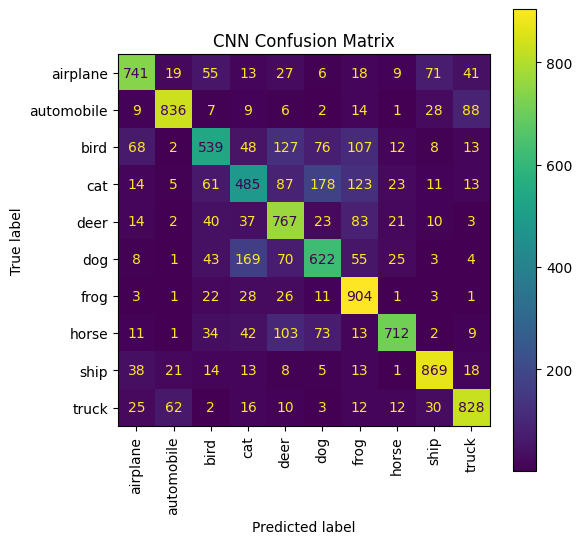

In [23]:
test_loss, test_acc = model_CNN.evaluate(x_test_nn, y_test_nn, verbose=0)
print("Keras accuracy: "+str(test_acc))

report_CNN, predictions_CNN = eval_model(x_test_nn, y_test_nn, model_CNN, invert_one_hot_encoding=True)
plot_evalueted_model("CNN", report_CNN, predictions_CNN, title="CNN Confusion Matrix")


### 3.3 Confronto tra modelli  

Si vogliono adesso confrontare i risultati dei modelli ottenuti sia in riferimento all'accuratezza che in riferimento alla precisione sulle singole classi.

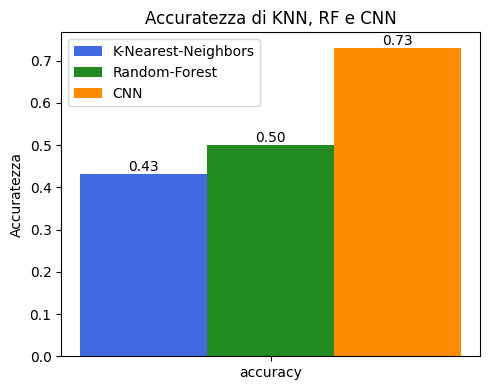

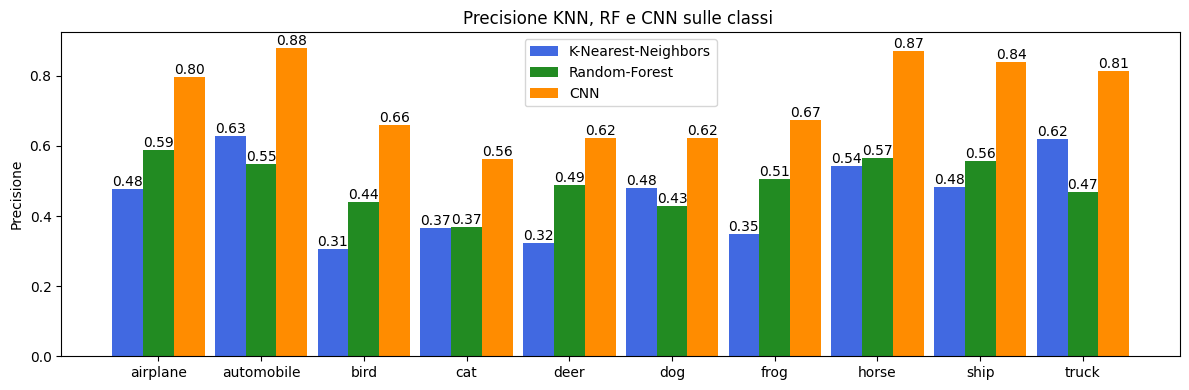

In [24]:
report_dict = {"K-Nearest-Neighbors": report_KNN,
               "Random-Forest": report_RF,
               "CNN": report_CNN,
              }
color = {"K-Nearest-Neighbors": "royalblue", 
         "Random-Forest": "forestgreen",
         "CNN": "darkorange",
        }

# Accuratezza
compared_report_accuracy = compare_report(report_dict, compare_metric_list=["accuracy"])
plot_compared_report(compared_report_accuracy, 
                     color=color,
                     title="Accuratezza di KNN, RF e CNN",
                     width_bar=0.01,
                     fig_size=(5,4),
                     y_label="Accuratezza",
                     x_label="",
                    )   

# Precisione tra le classi
compared_report_classes = compare_report(report_dict, 
                                         compare_metric_list=[*[ str(i)+" | precision" for i in range(0, 10)] ])
# a ciascuna label associo un nome
compared_report_classes.index = [label_names[int(w[0])] for w in compared_report_classes.index.tolist()]
plot_compared_report(compared_report_classes, 
                     color=color,
                     title="Precisione KNN, RF e CNN sulle classi ",
                     width_bar=0.3,
                     fig_size=(12,4),
                     y_label="Precisione",
                     x_label="",
                    )   
    

In [90]:
KNN_time_model = KNeighborsClassifier(weights='distance', n_neighbors=10) 
RF_time_model = RandomForestClassifier(n_estimators=1024, n_jobs=-1)


def time_depnding_on_pca(model, x_train_, y_train_, x_test_):
    """
    for n_comp in [30, 200, 500]:
        pca = PCA(n_comp)
        pca.fit(x_train_)
        x_train_pca = pca.transform(x_train_)
        
        print("    PCA "+str(n_comp)+" --> ("+str(x_train_pca.shape[0])+","+str(x_train_pca.shape[1])+"):")
        
        start = time.time()
        model.fit(x_train_pca, y_train_)
        stop = time.time()
        
        print("        Training time:"+str(stop - start)+"s")
    """    
    print("    NO PCA:")    
    start = time.time()
    model.fit(x_train_, y_train_)
    stop = time.time()
    print("        Training time: "+str(stop - start)+"s")        
        
        
print("KNN:")        
time_depnding_on_pca(KNN_time_model, x_train, y_train, x_test)

print("\n\nRandom Forest:")
time_depnding_on_pca(RF_time_model, x_train, y_train, x_test)


KNN:
    NO PCA:
        Training time: 0.8016090393066406s


Random Forest:
    NO PCA:
        Training time: 1195.716565132141s


In [39]:

def measure_prediction_time(model, name):
    start = time.time()
    model.predict(x_test) if name != "CNN" else model.predict(x_test_nn)
    stop = time.time()
    print("Model: "+name)
    print("    Prediction time: "+str(stop - start)+"s") 
    
for name, model in {"KNN": model_KNN, "RF": model_RF, "CNN": model_CNN}.items():
    measure_prediction_time(model, name)
    